In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.client import device_lib

config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 

tf.keras.backend.set_session(sess)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[u'/device:GPU:0']

In [2]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

In [3]:
import json
import time

def save_history(history, filename):
    with open(filename + '_%s.json' % str(time.time()), 'w') as f:
        json.dump(history, f)

def load_history(filename):
    with open(filename) as json_file:  
        return json.load(json_file)
        
def save_weights(model, file):
    model.save_weights(file + "_%s.h5" % str(time.time()))
        
def join_histories(h1, h2):
    return {
        'acc': h1['acc'] + h2['acc'],
        'loss': h1['loss'] + h2['loss'],
        'val_acc': h1['val_acc'] + h2['val_acc'],
        'val_loss': h1['val_loss'] + h2['val_loss']
    }
        
# checkpoint
filepath="weights-improvement-mt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

## Analysis of the dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]

print("number of classes:", num_classes)
print("input shape:", input_shape)
print("Image data type:", x_train.dtype)

('x_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')
('number of classes:', 10)
('input shape:', (32, 32, 3))
('Image data type:', dtype('uint8'))


The dataset consists of 60000 images of size 32x32 pixels. The images are rgb (3 channels). There are 10 classes in the dataset.

### Visualisation of the dataset

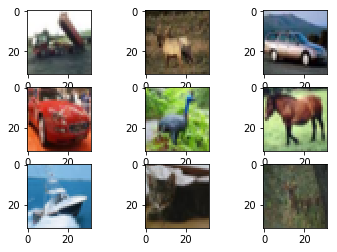

In [5]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 1])

(50000, 1)


<BarContainer object of 10 artists>

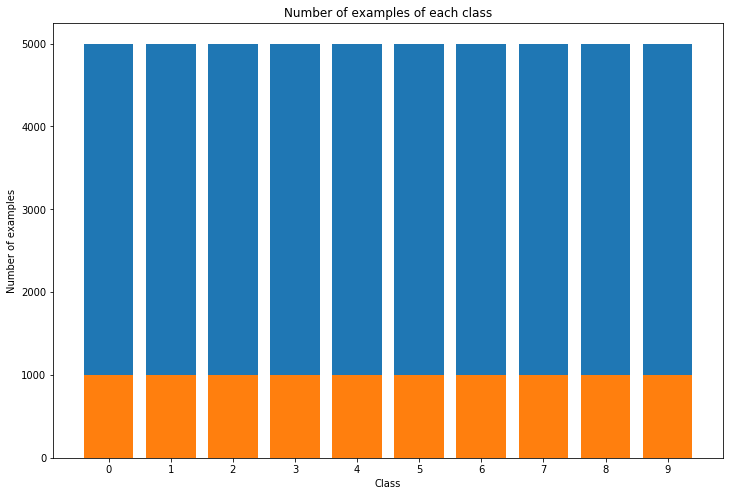

In [6]:
print(y_train.shape)
class_distribution_train = Counter(y_train[:,0])
class_distribution_test = Counter(y_test[:,0])
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The dataset is evenly distributed across the 10 classes.

### Normalize the dataset

In [7]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Split out validation data

In [8]:
train_val_split = 0.85 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val_data = x_train[idx_val]
y_val_data = y_train[idx_val]

x_train_data = x_train[idx_train]
y_train_data = y_train[idx_train]

print("Training images:", x_train_data.shape)
print("Validation images:", x_val_data.shape)
print("Test images:", x_test.shape)

('Training images:', (42500, 32, 32, 3))
('Validation images:', (7500, 32, 32, 3))
('Test images:', (10000, 32, 32, 3))


### Data augmentation

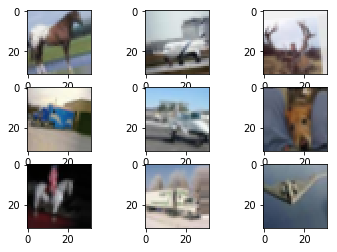

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_data)

for x_batch, y_batch in datagen.flow(x_train_data,
                                     y_train_data,
                                     batch_size=9):
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
    plt.show()
    break

Data augmentation rotates, shifts and flips the images, and gives us more varied training data, thus preventing overfitting

## Implementing a known model

### Model definition

In [36]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPool2D())

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.Dense(num_classes))
model1.add(tf.keras.layers.Activation('softmax'))

### Training the model

In [37]:
opt = 'adam'

model1.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model1_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [32]:
batch_size = 64
epochs = 10

h = model1.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model1_history = join_histories(model1_history, h.history)
save_history(model1_history, "model1_history")
save_weights(model1, "model1")

Epoch 1/15
665/665 [==============================] - 19s 29ms/step - loss: 1.7212 - acc: 0.3591 - val_loss: 1.4434 - val_acc: 0.4703
Epoch 2/15
665/665 [==============================] - 15s 23ms/step - loss: 1.4165 - acc: 0.4802 - val_loss: 1.2686 - val_acc: 0.5525
Epoch 3/15
665/665 [==============================] - 15s 23ms/step - loss: 1.2858 - acc: 0.5369 - val_loss: 1.2065 - val_acc: 0.5825
Epoch 4/15
665/665 [==============================] - 15s 23ms/step - loss: 1.1923 - acc: 0.5734 - val_loss: 1.0528 - val_acc: 0.6321
Epoch 5/15
665/665 [==============================] - 15s 23ms/step - loss: 1.1252 - acc: 0.6004 - val_loss: 1.0267 - val_acc: 0.6436
Epoch 6/15
665/665 [==============================] - 15s 23ms/step - loss: 1.0589 - acc: 0.6197 - val_loss: 0.9538 - val_acc: 0.6683
Epoch 7/15
665/665 [==============================] - 15s 23ms/step - loss: 1.0216 - acc: 0.6358 - val_loss: 0.9600 - val_acc: 0.6669
Epoch 8/15
665/665 [==============================] - 15s 23ms

### Model evaluation and results

In [42]:
model1.load_weights("model1_1542800949.72.h5")
model1_history = load_history("model1_history_1542800949.72.json")

In [43]:
evaluate_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
__________

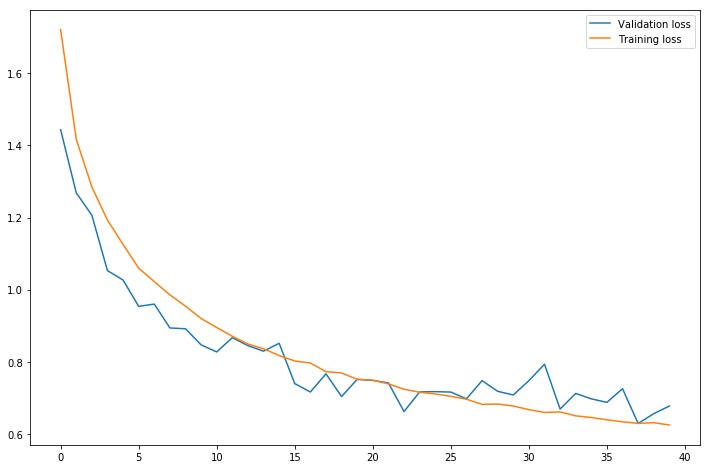

In [44]:
visualize_loss_history(model1_history)

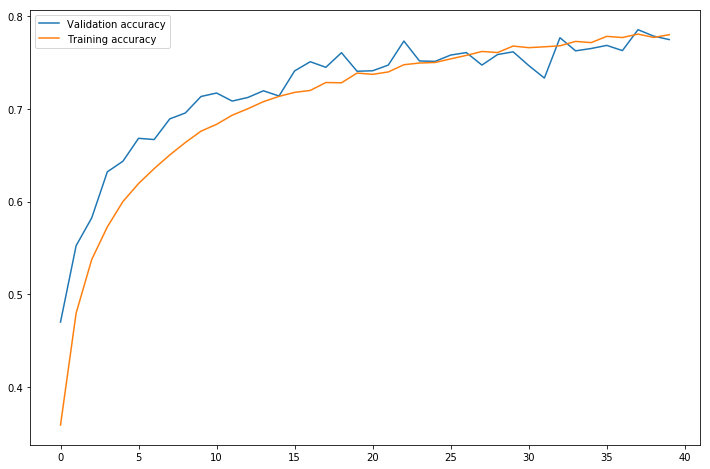

In [46]:
visualize_accuracy_history(model1_history)

After 40 iterations, we begin to observe reduced improvements in training, and are beginning to overfit.

The model achieves a test accuracy of 77.3% which is impressive considering the simplicity of the model.

### Training our MNIST model

In [21]:
model_mnist = tf.keras.models.Sequential()
model_mnist.add(tf.keras.layers.Flatten(input_shape=input_shape))
model_mnist.add(tf.keras.layers.Dense(784, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.40))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.50))
model_mnist.add(tf.keras.layers.Dense(256, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(128, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.40))
model_mnist.add(tf.keras.layers.Dense(128, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
opt = 'adam'

model_mnist.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_mnist_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [27]:
batch_size = 64
epochs = 10

h = model_mnist.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val_data, y_val_data),
                    shuffle=True)
model_mnist_history = join_histories(model_mnist_history, h.history)
save_history(model_mnist_history, "model_mnist_history")
save_weights(model_mnist, "model_mnist")

Epoch 1/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7196 - acc: 0.3864 - val_loss: 1.6407 - val_acc: 0.4128
Epoch 2/10
665/665 [==============================] - 14s 22ms/step - loss: 1.7146 - acc: 0.3881 - val_loss: 1.6003 - val_acc: 0.4155
Epoch 3/10
665/665 [==============================] - 14s 22ms/step - loss: 1.7148 - acc: 0.3877 - val_loss: 1.6448 - val_acc: 0.4083
Epoch 4/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7169 - acc: 0.3853 - val_loss: 1.6201 - val_acc: 0.4176
Epoch 5/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7208 - acc: 0.3824 - val_loss: 1.6237 - val_acc: 0.4249
Epoch 6/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7183 - acc: 0.3850 - val_loss: 1.6243 - val_acc: 0.4176
Epoch 7/10
665/665 [==============================] - 14s 21ms/step - loss: 1.7124 - acc: 0.3891 - val_loss: 1.6346 - val_acc: 0.4096
Epoch 8/10
665/665 [==============================] - 15s 22ms

In [31]:
model_mnist.load_weights("model_mnist_1542808197.58.h5")
model_mnist_history = load_history("model_mnist_history_1542808197.58.json")

In [32]:
evaluate_model(model_mnist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 784)               2409232   
_________________________________________________________________
dense_33 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
__________

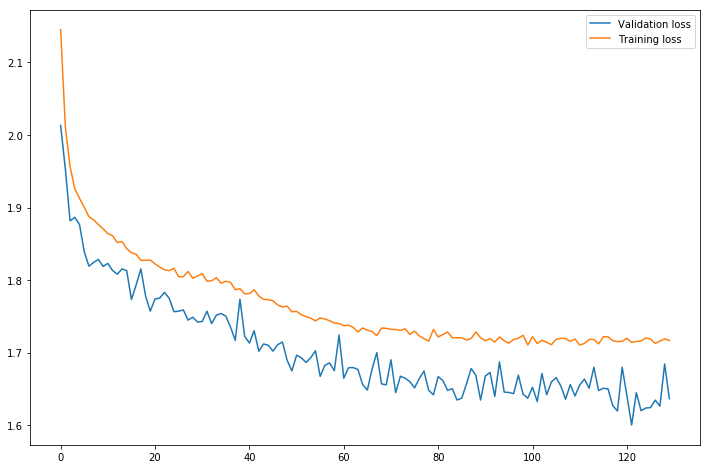

In [33]:
visualize_loss_history(model_mnist_history)

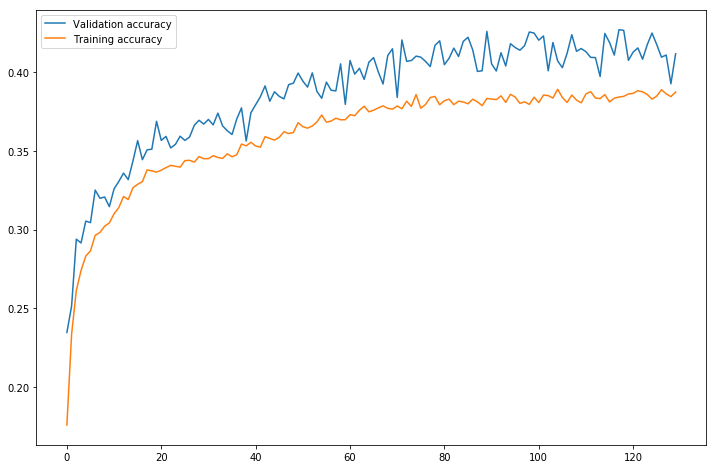

In [34]:
visualize_accuracy_history(model_mnist_history)

Our MNIST fully connected model did not perform as good on the CIFAR-10 dataset, with an accuracy score of 42.1%. This is probably due to the differences in the two datasets. The MNIST dataset consists of simple grayscale images of numbers, which contains only a few basic lines and shapes, in contrast to the CIFAR-10 dataset which consists of much more abstract shapes and objects. CNNs are far superior to fully connected networks when it comes to recognizing features, shapes and groups of shapes than a fully connected network, thus it would naturally perform better.

Furthermore we must take into consideration that the CIFAR-10 dataset consists of 3 channel rgb images, whereas the MNIST dataset only consists of 1 channel. When flattening the image in the MNIST model, we lose information about how the three layers are overlaying, this information is preserved in a convolutional network, thus making it easier to connect shapes across the color channels.

### Training a simple model
Looking at model1 which scored an accuracy of 77.3%, we use this as a base to create the simplest model achieving over 70%.

In [10]:
model_simple = tf.keras.models.Sequential()
model_simple.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model_simple.add(tf.keras.layers.MaxPool2D())
model_simple.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_simple.add(tf.keras.layers.MaxPool2D())
model_simple.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_simple.add(tf.keras.layers.MaxPool2D())

model_simple.add(tf.keras.layers.Flatten())
model_simple.add(tf.keras.layers.Dense(64, activation='relu'))
model_simple.add(tf.keras.layers.Dense(32, activation='relu'))
model_simple.add(tf.keras.layers.Dense(num_classes))
model_simple.add(tf.keras.layers.Activation('softmax'))

In [11]:
opt = 'adam'

model_simple.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_simple_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [28]:
batch_size = 64
epochs = 10

h = model_simple.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model_simple_history = join_histories(model_simple_history, h.history)
save_history(model_simple_history, "model_simple_history")
save_weights(model_simple, "model_simple")

Epoch 1/10
665/665 [==============================] - 14s 21ms/step - loss: 0.9210 - acc: 0.6769 - val_loss: 0.9132 - val_acc: 0.6783
Epoch 2/10
665/665 [==============================] - 14s 21ms/step - loss: 0.9078 - acc: 0.6807 - val_loss: 0.8630 - val_acc: 0.6961
Epoch 3/10
665/665 [==============================] - 14s 21ms/step - loss: 0.9002 - acc: 0.6840 - val_loss: 0.8754 - val_acc: 0.6945
Epoch 4/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8962 - acc: 0.6857 - val_loss: 0.8660 - val_acc: 0.6959
Epoch 5/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8944 - acc: 0.6848 - val_loss: 0.8468 - val_acc: 0.7059
Epoch 6/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8873 - acc: 0.6883 - val_loss: 0.9336 - val_acc: 0.6724
Epoch 7/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8791 - acc: 0.6947 - val_loss: 0.8315 - val_acc: 0.7111
Epoch 8/10
665/665 [==============================] - 14s 21ms

In [23]:
evaluate_model(model_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
__________

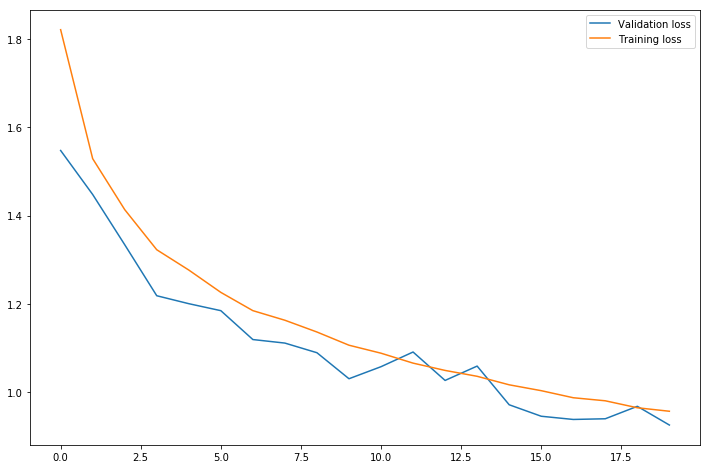

In [24]:
visualize_loss_history(model_simple_history)

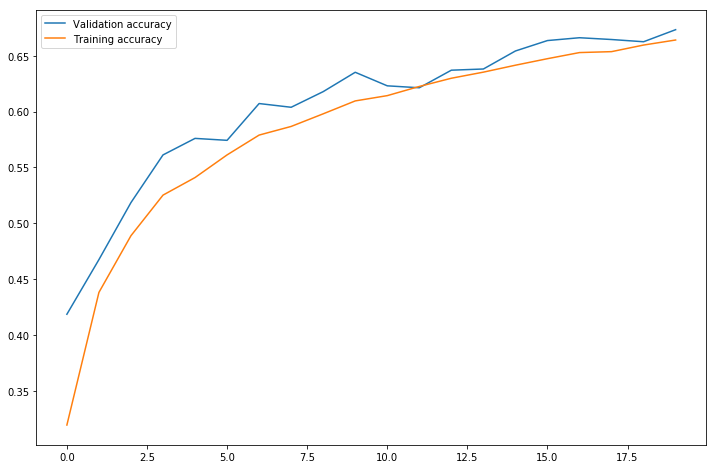

In [25]:
visualize_accuracy_history(model_simple_history)

### Model 3

In [56]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(32, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())

model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())
           
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(256))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Dense(128))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(64))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dense(num_classes))
model3.add(tf.keras.layers.Activation('softmax'))

In [57]:
opt = 'adam'

model3.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model3_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [77]:
epochs = 200

h = model3.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model3_history = join_histories(model3_history, h.history)
save_history(model3_history, "model3_history")
save_weights(model3, "model3")

Epoch 1/200
665/665 [==============================] - 16s 24ms/step - loss: 0.7232 - acc: 0.7581 - val_loss: 0.7617 - val_acc: 0.7427
Epoch 2/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7263 - acc: 0.7570 - val_loss: 0.7232 - val_acc: 0.7528
Epoch 3/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7143 - acc: 0.7618 - val_loss: 0.7207 - val_acc: 0.7548
Epoch 4/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7037 - acc: 0.7659 - val_loss: 0.7085 - val_acc: 0.7645
Epoch 5/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7130 - acc: 0.7645 - val_loss: 0.8684 - val_acc: 0.7152
Epoch 6/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6906 - acc: 0.7712 - val_loss: 0.7262 - val_acc: 0.7579
Epoch 7/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6846 - acc: 0.7702 - val_loss: 0.6514 - val_acc: 0.7803
Epoch 8/200
665/665 [==============================] - 

665/665 [==============================] - 16s 24ms/step - loss: 0.4544 - acc: 0.8495 - val_loss: 0.5086 - val_acc: 0.8300
Epoch 122/200
665/665 [==============================] - 16s 25ms/step - loss: 0.4509 - acc: 0.8501 - val_loss: 0.5824 - val_acc: 0.8127
Epoch 123/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4538 - acc: 0.8532 - val_loss: 0.5263 - val_acc: 0.8261
Epoch 124/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4579 - acc: 0.8493 - val_loss: 0.5639 - val_acc: 0.8157
Epoch 125/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4619 - acc: 0.8457 - val_loss: 0.5311 - val_acc: 0.8259
Epoch 126/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4581 - acc: 0.8488 - val_loss: 0.5537 - val_acc: 0.8132
Epoch 127/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4571 - acc: 0.8519 - val_loss: 0.6606 - val_acc: 0.7875
Epoch 128/200
665/665 [==============================] 

In [91]:
evaluate_model(model3)
save_weights(model3, "model3")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
__________

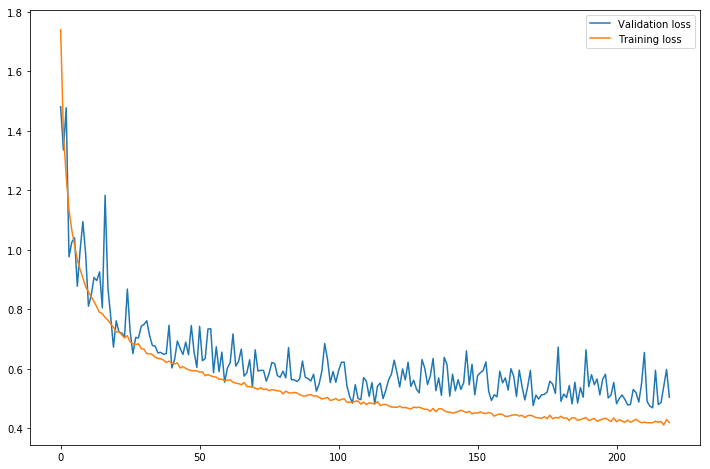

In [92]:
visualize_loss_history(model3_history)

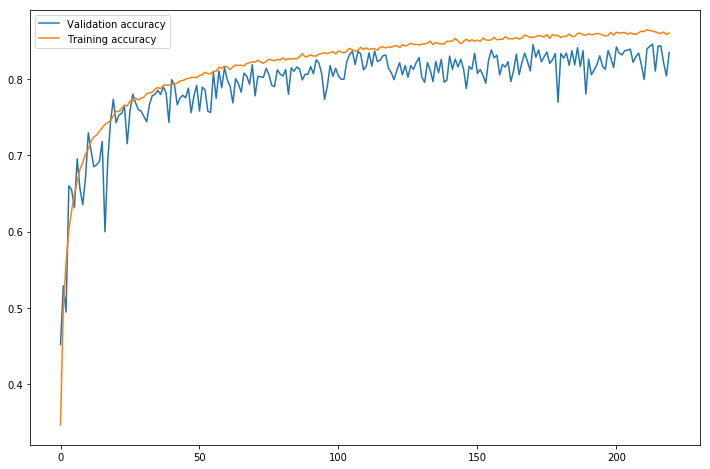

In [93]:
visualize_accuracy_history(model3_history)

## Transfer learning
### Model definition
Use VGG16 model trained on imagenet (without the last classifier layer). Then retrain the 2 last layers of vgg and add a new classifier layer.

In [10]:
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_shape=x_train_data.shape[1:])

# Disable training on all layers except last three
for layer in vgg_model.layers[:-3]:
    layer.trainable = False

model_t = tf.keras.models.Sequential()
model_t.add(vgg_model)
model_t.add(tf.keras.layers.Flatten())
model_t.add(tf.keras.layers.Dense(512, activation="relu"))
model_t.add(tf.keras.layers.Dropout(0.2))
model_t.add(tf.keras.layers.Dense(256, activation="relu"))
model_t.add(tf.keras.layers.Dropout(0.2))
model_t.add(tf.keras.layers.Dense(128, activation="relu"))
model_t.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
batch_size = 64
epochs = 10

In [11]:
opt = 'adam'

model_t.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_t_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

# checkpoint
filepath="transfer-vgg16-chkpnt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

In [ ]:
for i in range(100):
    h = model_t.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val_data, y_val_data),
                          callbacks=callbacks_list,
                          shuffle=True)

    model_t_history = join_histories(model_t_history, h.history)
    save_history(model_t_history, "model_t_history")
    save_weights(model_t, "model_t")

Epoch 1/10
664/665 [============================>.] - ETA: 0s - loss: 0.9848 - acc: 0.6652
Epoch 00001: val_acc improved from 0.68507 to 0.69387, saving model to transfer-vgg16-chkpnt-001-0.69.hdf5
665/665 [==============================] - 21s 32ms/step - loss: 0.9848 - acc: 0.6652 - val_loss: 0.8958 - val_acc: 0.6939
Epoch 2/10
664/665 [============================>.] - ETA: 0s - loss: 0.9527 - acc: 0.6751
Epoch 00002: val_acc did not improve from 0.69387
665/665 [==============================] - 21s 32ms/step - loss: 0.9529 - acc: 0.6751 - val_loss: 0.8832 - val_acc: 0.6863
Epoch 3/10
664/665 [============================>.] - ETA: 0s - loss: 0.9331 - acc: 0.6809
Epoch 00003: val_acc improved from 0.69387 to 0.71027, saving model to transfer-vgg16-chkpnt-003-0.71.hdf5
665/665 [==============================] - 21s 32ms/step - loss: 0.9334 - acc: 0.6807 - val_loss: 0.8574 - val_acc: 0.7103
Epoch 4/10
664/665 [============================>.] - ETA: 0s - loss: 0.9078 - acc: 0.6890
Epo

Epoch 1/10
664/665 [============================>.] - ETA: 0s - loss: 0.6519 - acc: 0.7757
Epoch 00001: val_acc improved from 0.72467 to 0.72587, saving model to transfer-vgg16-chkpnt-001-0.73.hdf5
665/665 [==============================] - 21s 31ms/step - loss: 0.6519 - acc: 0.7756 - val_loss: 0.8460 - val_acc: 0.7259
Epoch 2/10
664/665 [============================>.] - ETA: 0s - loss: 0.6421 - acc: 0.7784
Epoch 00002: val_acc did not improve from 0.72587
665/665 [==============================] - 21s 31ms/step - loss: 0.6418 - acc: 0.7784 - val_loss: 0.8811 - val_acc: 0.7152
Epoch 3/10
664/665 [============================>.] - ETA: 0s - loss: 0.6402 - acc: 0.7793
Epoch 00003: val_acc did not improve from 0.72587
665/665 [==============================] - 21s 31ms/step - loss: 0.6401 - acc: 0.7793 - val_loss: 0.8887 - val_acc: 0.7157
Epoch 4/10
664/665 [============================>.] - ETA: 0s - loss: 0.6287 - acc: 0.7831
Epoch 00004: val_acc did not improve from 0.72587
665/665 [=

Epoch 2/10
664/665 [============================>.] - ETA: 0s - loss: 0.5035 - acc: 0.8313
Epoch 00002: val_acc did not improve from 0.72587
665/665 [==============================] - 20s 31ms/step - loss: 0.5046 - acc: 0.8311 - val_loss: 0.9700 - val_acc: 0.7207
Epoch 3/10
664/665 [============================>.] - ETA: 0s - loss: 0.4913 - acc: 0.8349
Epoch 00003: val_acc did not improve from 0.72587
665/665 [==============================] - 20s 31ms/step - loss: 0.4915 - acc: 0.8349 - val_loss: 0.9816 - val_acc: 0.7156
Epoch 4/10
664/665 [============================>.] - ETA: 0s - loss: 0.4895 - acc: 0.8343
Epoch 00004: val_acc did not improve from 0.72587
665/665 [==============================] - 20s 31ms/step - loss: 0.4899 - acc: 0.8343 - val_loss: 0.9988 - val_acc: 0.7172
Epoch 5/10
664/665 [============================>.] - ETA: 0s - loss: 0.4863 - acc: 0.8354
Epoch 00005: val_acc did not improve from 0.72587
665/665 [==============================] - 20s 31ms/step - loss: 0.

In [13]:
model_t.load_weights("model_t_1542762988.67.h5")
model_t_history = load_history("model_t_history_1542762988.67.json")

In [14]:
evaluate_model(model_t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

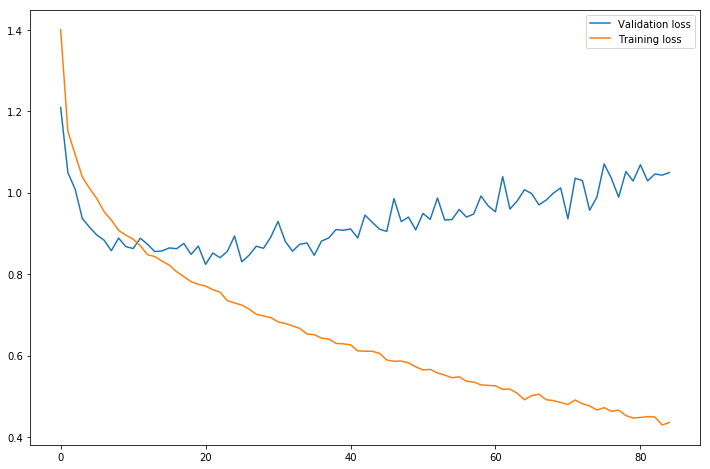

In [15]:
visualize_loss_history(model_t_history)

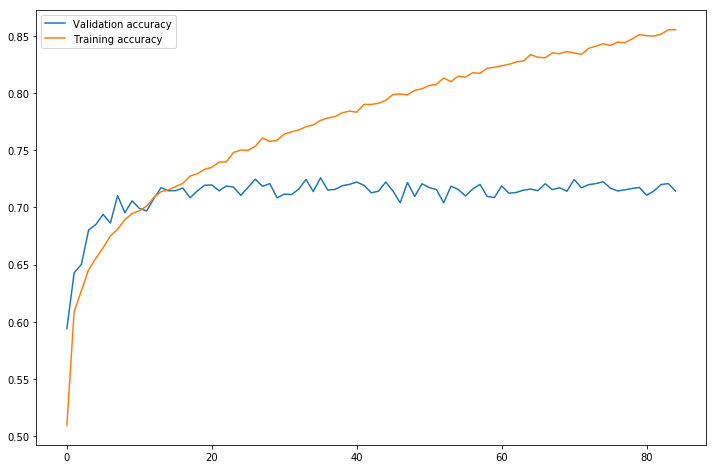

In [16]:
visualize_accuracy_history(model_t_history)

### Transfer Learning using ResNet50

In [11]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=x_train_data.shape[1:])

# Disable training on all layers except last six
for layer in resnet50_model.layers[:-6]:
    layer.trainable = False

for layer in resnet50_model.layers[-6:]:
    print(layer)
    layer.trainable = True

model_t_resnet = tf.keras.models.Sequential()
model_t_resnet.add(resnet50_model)
model_t_resnet.add(tf.keras.layers.GlobalAveragePooling2D())
model_t_resnet.add(tf.keras.layers.Dense(512, activation="relu"))
model_t_resnet.add(tf.keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python2.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
opt = tf.keras.optimizers.Adam(lr = 0.001)



model_t_resnet.compile(loss='categorical_crossentropy',
                       optimizer=opt,
                       metrics=['accuracy'])

model_t_resnet_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

# checkpoint
filepath="mtr-chkpnt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

In [13]:
batch_size = 64
epochs = 5

In [ ]:
for i in range(1):
    h = model_t_resnet.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(x_val_data, y_val_data),
                           callbacks=callbacks_list,
                           shuffle=True)

    model_t_resnet_history = join_histories(model_t_resnet_history, h.history)
    save_history(model_t_resnet_history, "model_t_resnet_history")
    save_weights(model_t_resnet, "model_t_resnet")

Epoch 1/5
663/665 [============================>.] - ETA: 0s - loss: 1.6528 - acc: 0.4259

In [ ]:
evaluate_model(model_t_resnet)

In [ ]:
visualize_loss_history(model_t_resnet_history)

In [ ]:
visualize_accuracy_history(model_t_resnet_history)